In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *
from Adam import Adam
from scipy import integrate
from SPNO_2d import *
from scipy.stats import multivariate_normal
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = "0" 
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
x_data = np.load('data/spde_2d_x.npy')
y_data = np.load('data/spde_2d_y.npy')

In [3]:
x_grid = np.linspace(0, 1, x_data.shape[-1])
y_grid = x_grid

ntrain = 900
ntest = 100

batch_size = 20
learning_rate = 0.001

epochs = 800
step_size = 100
gamma = 0.5

modes1 = 12
modes2 = 12
width1 = 16
width2 = 16

x_train = x_data[:ntrain,::2,::2]
y_train = y_data[:ntrain,::2,::2]
x_test = x_data[-ntest:,::2,::2]
y_test = y_data[-ntest:,::2,::2]
x_grid = x_grid[::2]
y_grid = y_grid[::2]

x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)
x_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test)


x_train = torch.reshape(x_train,(x_train.shape[0],x_train.shape[1],x_train.shape[2],1))
x_test = torch.reshape(x_test,(x_test.shape[0],x_test.shape[1],x_train.shape[2],1))

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

model = SPNO2d(modes1, modes2, width1, width2, 1/2**5, x_grid.shape[0], y_grid.shape[0]).cuda()
print('Total parameters:',count_params(model))

optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

start = default_timer()

MSE = torch.zeros(epochs)
L2 = torch.zeros(epochs)

myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward()
        
        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()
        
    scheduler.step()
    
    train_mse /= len(train_loader)
    train_l2 /= ntrain
    t2 = default_timer()
    
    MSE[ep] = train_mse
    L2[ep] = train_l2
    print('\repoch {:d}/{:d} L2 = {:.6f}, MSE = {:.6f}, using {:.6f}s'.format(ep+1,epochs,train_l2,train_mse,t2-t1), end='\n', flush=True)

print('Total training time:',default_timer()-start,'s')

Total parameters: 1198918
epoch 1/800 L2 = 0.701090, MSE = 0.086720, using 5.124987s
epoch 2/800 L2 = 0.176319, MSE = 0.002556, using 2.741879s
epoch 3/800 L2 = 0.113172, MSE = 0.000997, using 2.751616s
epoch 4/800 L2 = 0.083802, MSE = 0.000528, using 2.738177s
epoch 5/800 L2 = 0.072690, MSE = 0.000392, using 2.731726s
epoch 6/800 L2 = 0.052877, MSE = 0.000204, using 2.750242s
epoch 7/800 L2 = 0.064556, MSE = 0.000453, using 2.742395s
epoch 8/800 L2 = 0.051842, MSE = 0.000300, using 2.747366s
epoch 9/800 L2 = 0.061066, MSE = 0.000547, using 2.747414s
epoch 10/800 L2 = 0.053483, MSE = 0.000387, using 2.762885s
epoch 11/800 L2 = 0.043163, MSE = 0.000249, using 2.754672s
epoch 12/800 L2 = 0.043927, MSE = 0.000228, using 2.749137s
epoch 13/800 L2 = 0.058017, MSE = 0.000478, using 2.759778s
epoch 14/800 L2 = 0.037640, MSE = 0.000190, using 2.747541s
epoch 15/800 L2 = 0.025439, MSE = 0.000076, using 2.733122s
epoch 16/800 L2 = 0.036044, MSE = 0.000146, using 2.742926s
epoch 17/800 L2 = 0.037

epoch 137/800 L2 = 0.008351, MSE = 0.000008, using 2.951763s
epoch 138/800 L2 = 0.011289, MSE = 0.000013, using 2.893947s
epoch 139/800 L2 = 0.009506, MSE = 0.000010, using 2.925761s
epoch 140/800 L2 = 0.008804, MSE = 0.000008, using 2.973083s
epoch 141/800 L2 = 0.008711, MSE = 0.000007, using 2.848637s
epoch 142/800 L2 = 0.009743, MSE = 0.000011, using 2.907501s
epoch 143/800 L2 = 0.008171, MSE = 0.000007, using 2.972208s
epoch 144/800 L2 = 0.007590, MSE = 0.000007, using 2.909887s
epoch 145/800 L2 = 0.008646, MSE = 0.000009, using 2.872681s
epoch 146/800 L2 = 0.014209, MSE = 0.000024, using 2.944147s
epoch 147/800 L2 = 0.010028, MSE = 0.000012, using 2.735287s
epoch 148/800 L2 = 0.008590, MSE = 0.000008, using 2.860501s
epoch 149/800 L2 = 0.009450, MSE = 0.000012, using 2.764062s
epoch 150/800 L2 = 0.007607, MSE = 0.000007, using 2.786820s
epoch 151/800 L2 = 0.009490, MSE = 0.000011, using 2.763307s
epoch 152/800 L2 = 0.010405, MSE = 0.000013, using 2.761145s
epoch 153/800 L2 = 0.009

epoch 272/800 L2 = 0.004122, MSE = 0.000002, using 2.982734s
epoch 273/800 L2 = 0.005714, MSE = 0.000005, using 3.013339s
epoch 274/800 L2 = 0.005114, MSE = 0.000003, using 2.888214s
epoch 275/800 L2 = 0.004328, MSE = 0.000002, using 2.887118s
epoch 276/800 L2 = 0.003840, MSE = 0.000002, using 2.949730s
epoch 277/800 L2 = 0.004745, MSE = 0.000003, using 2.899936s
epoch 278/800 L2 = 0.003637, MSE = 0.000002, using 2.853262s
epoch 279/800 L2 = 0.004273, MSE = 0.000002, using 2.743584s
epoch 280/800 L2 = 0.004702, MSE = 0.000003, using 2.744591s
epoch 281/800 L2 = 0.003945, MSE = 0.000002, using 2.785184s
epoch 282/800 L2 = 0.004444, MSE = 0.000002, using 2.923967s
epoch 283/800 L2 = 0.005696, MSE = 0.000004, using 2.875973s
epoch 284/800 L2 = 0.004475, MSE = 0.000002, using 2.837309s
epoch 285/800 L2 = 0.004292, MSE = 0.000002, using 2.814254s
epoch 286/800 L2 = 0.004087, MSE = 0.000002, using 2.806110s
epoch 287/800 L2 = 0.005872, MSE = 0.000005, using 2.843114s
epoch 288/800 L2 = 0.003

epoch 407/800 L2 = 0.001848, MSE = 0.000001, using 2.736361s
epoch 408/800 L2 = 0.002037, MSE = 0.000001, using 2.742246s
epoch 409/800 L2 = 0.001866, MSE = 0.000001, using 2.747759s
epoch 410/800 L2 = 0.002100, MSE = 0.000001, using 2.756927s
epoch 411/800 L2 = 0.001972, MSE = 0.000001, using 2.809670s
epoch 412/800 L2 = 0.001982, MSE = 0.000001, using 2.948525s
epoch 413/800 L2 = 0.001841, MSE = 0.000000, using 2.913708s
epoch 414/800 L2 = 0.001858, MSE = 0.000000, using 2.830605s
epoch 415/800 L2 = 0.001886, MSE = 0.000001, using 2.795839s
epoch 416/800 L2 = 0.001867, MSE = 0.000000, using 2.761851s
epoch 417/800 L2 = 0.001888, MSE = 0.000001, using 2.768810s
epoch 418/800 L2 = 0.001910, MSE = 0.000001, using 2.757335s
epoch 419/800 L2 = 0.002154, MSE = 0.000001, using 2.784157s
epoch 420/800 L2 = 0.002185, MSE = 0.000001, using 2.763040s
epoch 421/800 L2 = 0.002655, MSE = 0.000001, using 2.912658s
epoch 422/800 L2 = 0.002024, MSE = 0.000001, using 2.866443s
epoch 423/800 L2 = 0.002

epoch 542/800 L2 = 0.001658, MSE = 0.000000, using 2.763794s
epoch 543/800 L2 = 0.001603, MSE = 0.000000, using 2.738683s
epoch 544/800 L2 = 0.001954, MSE = 0.000001, using 2.737522s
epoch 545/800 L2 = 0.001677, MSE = 0.000000, using 2.728178s
epoch 546/800 L2 = 0.001571, MSE = 0.000000, using 2.751162s
epoch 547/800 L2 = 0.001584, MSE = 0.000000, using 2.748231s
epoch 548/800 L2 = 0.001630, MSE = 0.000000, using 2.744718s
epoch 549/800 L2 = 0.001565, MSE = 0.000000, using 2.751104s
epoch 550/800 L2 = 0.001594, MSE = 0.000000, using 2.734785s
epoch 551/800 L2 = 0.001612, MSE = 0.000000, using 2.758185s
epoch 552/800 L2 = 0.001701, MSE = 0.000000, using 2.761244s
epoch 553/800 L2 = 0.001585, MSE = 0.000000, using 2.768112s
epoch 554/800 L2 = 0.001524, MSE = 0.000000, using 2.732954s
epoch 555/800 L2 = 0.001600, MSE = 0.000000, using 2.753945s
epoch 556/800 L2 = 0.001648, MSE = 0.000000, using 2.736786s
epoch 557/800 L2 = 0.001641, MSE = 0.000000, using 2.737169s
epoch 558/800 L2 = 0.001

epoch 677/800 L2 = 0.001480, MSE = 0.000000, using 2.743913s
epoch 678/800 L2 = 0.001397, MSE = 0.000000, using 2.744094s
epoch 679/800 L2 = 0.001396, MSE = 0.000000, using 2.741975s
epoch 680/800 L2 = 0.001407, MSE = 0.000000, using 2.756357s
epoch 681/800 L2 = 0.001436, MSE = 0.000000, using 2.747965s
epoch 682/800 L2 = 0.001405, MSE = 0.000000, using 2.728793s
epoch 683/800 L2 = 0.001395, MSE = 0.000000, using 2.731827s
epoch 684/800 L2 = 0.001399, MSE = 0.000000, using 2.725085s
epoch 685/800 L2 = 0.001403, MSE = 0.000000, using 2.730531s
epoch 686/800 L2 = 0.001476, MSE = 0.000000, using 2.747233s
epoch 687/800 L2 = 0.001404, MSE = 0.000000, using 2.750692s
epoch 688/800 L2 = 0.001386, MSE = 0.000000, using 2.731326s
epoch 689/800 L2 = 0.001464, MSE = 0.000000, using 2.739409s
epoch 690/800 L2 = 0.001399, MSE = 0.000000, using 2.733588s
epoch 691/800 L2 = 0.001382, MSE = 0.000000, using 2.757372s
epoch 692/800 L2 = 0.001404, MSE = 0.000000, using 2.754216s
epoch 693/800 L2 = 0.001

In [4]:
'''
#test round using trained model
loss = np.load("data/SPNO_loss_2d.npy")
model = torch.load("model/SPNO_spde_2d")
x_data = np.load('data/spde_2d_x.npy')
y_data = np.load('data/spde_2d_y.npy')
x_grid = np.linspace(0, 1, x_data.shape[-1])
y_grid = x_grid
ntest = 100
x_test = x_data[-ntest:,::2,::2]
y_test = y_data[-ntest:,::2,::2]
x_grid = x_grid[::2]
y_grid = y_grid[::2]
x_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test)
x_test = torch.reshape(x_test,(x_test.shape[0],x_test.shape[1],x_test.shape[2],1))
myloss = LpLoss(size_average=False)
MSE = loss[0]
L2 = loss[1]
'''

'\n#test round using trained model\nloss = np.load("data/SPNO_loss_2d.npy")\nmodel = torch.load("model/SPNO_spde_2d")\nx_data = np.load(\'data/spde_2d_x.npy\')\ny_data = np.load(\'data/spde_2d_y.npy\')\nx_grid = np.linspace(0, 1, x_data.shape[-1])\ny_grid = x_grid\nntest = 100\nx_test = x_data[-ntest:,::2,::2]\ny_test = y_data[-ntest:,::2,::2]\nx_grid = x_grid[::2]\ny_grid = y_grid[::2]\nx_test = torch.Tensor(x_test)\ny_test = torch.Tensor(y_test)\nx_test = torch.reshape(x_test,(x_test.shape[0],x_test.shape[1],x_test.shape[2],1))\nmyloss = LpLoss(size_average=False)\nMSE = loss[0]\nL2 = loss[1]\n'

In [5]:
pred = torch.zeros(y_test.shape)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
index = 0
test_l2 = 0
test_mse = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda(), y.cuda()

        out = model(x).view(-1)
        pred[index] = out.reshape(y_test.shape[1], y_test.shape[2])
        mse = F.mse_loss(out.view(1, -1), y.view(1, -1), reduction='mean')
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        test_mse += mse.item()
        index += 1
        
    test_mse /= len(test_loader)
    test_l2 /= ntest
    print('test error: L2 =', test_l2,', MSE =',test_mse)

test error: L2 = 0.0014362105153850279 , MSE = 2.5071176350310865e-07


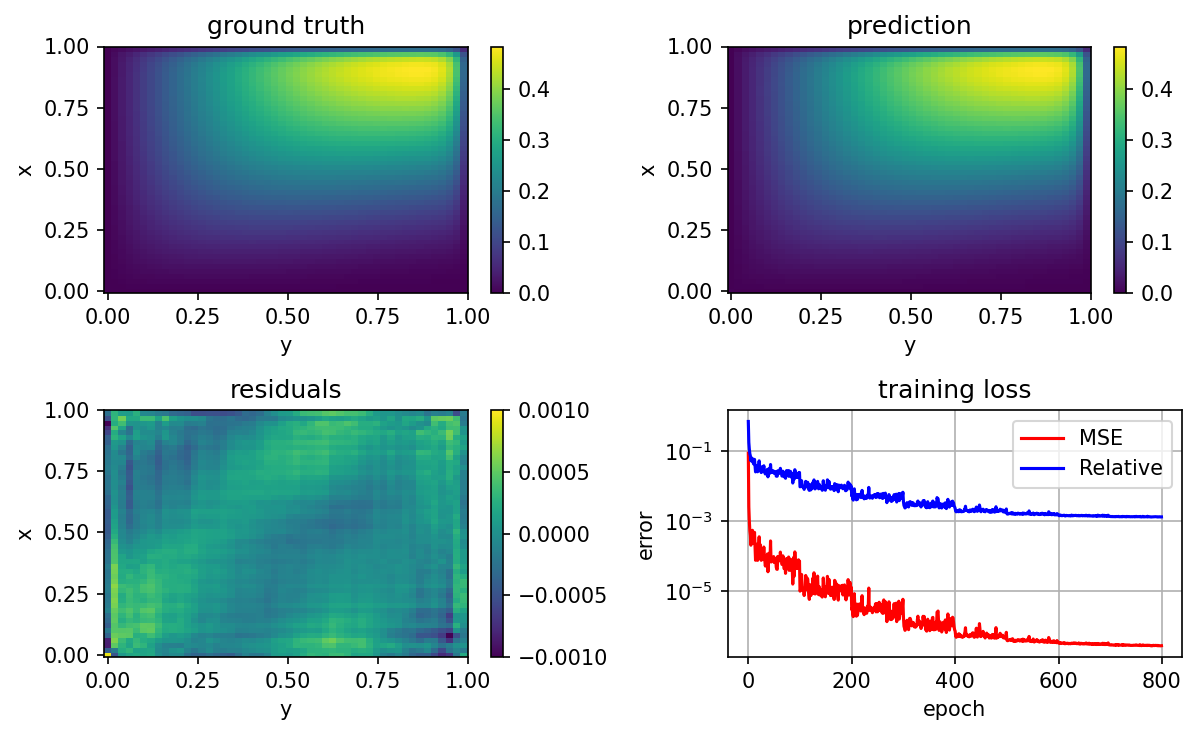

In [6]:
i = 71

X, Y = np.meshgrid(x_grid, y_grid)

residual = pred-y_test
fig = plt.figure(figsize=(8,5),dpi=150)

plt.subplot(2,2,1)
plt.title("ground truth")
plt.pcolormesh(X, Y, y_test[i], shading='auto')
plt.xlabel("y")
plt.ylabel("x")
plt.colorbar()

plt.subplot(2,2,2)
plt.title("prediction")
plt.pcolormesh(X, Y, pred[i], shading='auto')
plt.xlabel("y")
plt.ylabel("x")
plt.colorbar()

plt.subplot(2,2,3)
plt.title("residuals")
plt.pcolormesh(X, Y, residual[i], shading='auto',vmin=-0.001,vmax=0.001)
plt.xlabel("y")
plt.ylabel("x")
plt.colorbar()
    
plt.subplot(2,2,4)
plt.title("training loss")
plt.plot(MSE,c='r',label='MSE')
plt.plot(L2,c='b',label='Relative')
plt.legend()
plt.yscale('log')
plt.xlabel("epoch")
plt.ylabel("error")
plt.grid()

plt.tight_layout()
plt.show()

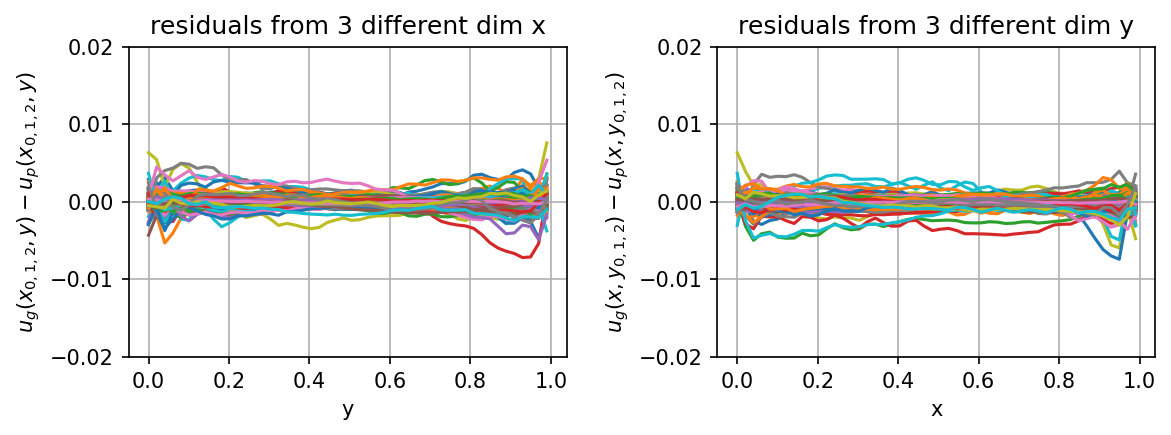

In [7]:
fig_1 = plt.figure(figsize=(8,3),dpi=150)

plt.subplot(1,2,1)
plt.title("residuals from 3 different dim x")
for j in range(ntest):
    for i in range(3):
        plt.plot(x_grid,residual[j,i*x_grid.shape[0]//3])
        plt.ylim((-0.02,0.02))
plt.xlabel("y")
plt.ylabel("$u_g(x_{0,1,2},y)-u_p(x_{0,1,2},y)$")
plt.grid()
   

plt.subplot(1,2,2)
plt.title("residuals from 3 different dim y")
for j in range(ntest):
    for i in range(3):
        plt.plot(x_grid,residual[j,:,i*(x_grid.shape[0]//3)])
        plt.ylim((-0.02,0.02))
plt.xlabel("x")
plt.ylabel("$u_g(x,y_{0,1,2})-u_p(x,y_{0,1,2})$")
plt.grid()

plt.tight_layout()
plt.show()

In [8]:
v = torch.zeros(ntest)
m = torch.zeros(ntest)
for i in range(ntest):
    v[i] = torch.var(residual[i],unbiased=False)
    m[i] = torch.mean(residual[i])
print(torch.mean(m),torch.mean(v))

tensor(-2.1974e-05) tensor(2.1991e-07)


In [9]:
mse = MSE.numpy().reshape(1,MSE.shape[0])
l2 = L2.numpy().reshape(1,L2.shape[0])
loss = np.concatenate((mse,l2))
np.save("data/spno_loss_2d.npy",loss)
torch.save(model,'model/spno_2d')